In [2]:
import pandas as pd
import numpy as np
import os
import json
import datetime
from datetime import timezone
from tqdm import tqdm

import femr.models.transformer
import torch
import femr.models.tokenizer
import femr.models.processor
from collections import defaultdict

model_name = "StanfordShahLab/clmbr-t-base"

In [3]:
def create_medical_records(time_list, code_list):
    records = {}

    for time, code in zip(time_list, code_list):
        if time in records:
            records[time].append({'code': code})
        else:
            records[time] = [{'code': code}]
    formatted_records = [{'time': time, 'measurements': codes} for time, codes in records.items()]
    return formatted_records

def create_structured_data(event_list, file_name):
    patient_data = {}
    patient_id = int(file_name.split('.')[0])
    patient_data['patient_id'] = patient_id
    patient_data['events'] = event_list
    return patient_data

def generate_embedding(patient_data, tokenizer, batch_processor, model):
    raw_batch = batch_processor.convert_patient(patient_data, tensor_type="pt")
    batch = batch_processor.collate([raw_batch])
    _, result = model(**batch)
    repr_array = result['representations'].detach().numpy()
    time_list = np.array([datetime.datetime.fromtimestamp(t, tz=timezone.utc) for t in result['timestamps'].numpy()])
    patient_id_list = result['patient_ids'].numpy()
    return repr_array, time_list, patient_id_list

def last_unique_datetime_indices(datetime_list):
    last_seen_indices = {}
    
    # Track the index of the last occurrence for each datetime object
    for idx, dt in enumerate(datetime_list):
        last_seen_indices[dt] = idx
    unique_indices = list(last_seen_indices.values())
    return np.array(unique_indices)

In [11]:
events_len = []

patient_info_dir = 'new_femr_dataset/patient_info'
patient_file_list = os.listdir(patient_info_dir)
birthday_code = 'SNOMED/184099003'

tokenizer = femr.models.tokenizer.FEMRTokenizer.from_pretrained(model_name)
batch_processor = femr.models.processor.FEMRBatchProcessor(tokenizer)
model = femr.models.transformer.FEMRModel.from_pretrained(model_name)

all_df = pd.DataFrame()

for f in tqdm(patient_file_list):
# for f in [patient_file_list[40]]:
    patient_file = os.path.join(patient_info_dir, f)
    with open(patient_file) as json_file:
        data = json.load(json_file)
        medical_token_list = data['medical_tokens']
        time_list = [datetime.datetime.fromisoformat(date) for date in data['time_tokens']]

        medical_token_list.insert(0, birthday_code)

        birthday_time = time_list[0]

        time_list = [birthday_time] + time_list

    ###############################################



    event_list = create_medical_records(time_list, medical_token_list)

    events_len.append(len(event_list))
    # patient_data = create_structured_data(event_list, f)
    # filtered_repr_array, filtered_time_list, filtered_patient_id_list = generate_embedding(patient_data, tokenizer, batch_processor, model)

    # unique_indices = last_unique_datetime_indices(filtered_time_list)

    # df_patient = pd.DataFrame(filtered_repr_array[unique_indices])

    # df_patient['time'] = [i.isoformat() for i in filtered_time_list[unique_indices]]

    # df_patient['patient_id'] = filtered_patient_id_list[unique_indices]

    # all_df = pd.concat([all_df, df_patient])


100%|██████████| 6275/6275 [01:20<00:00, 78.06it/s] 


Text(0, 0.5, 'Frequency')

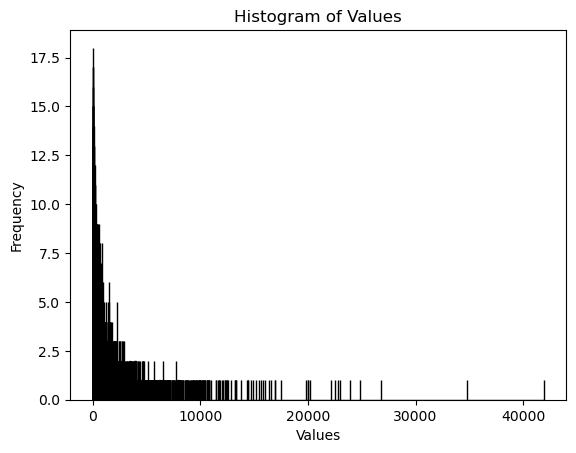

In [15]:
import matplotlib.pyplot as plt

# Your list of values
data = events_len

# Create a histogram
plt.hist(data, bins=range(min(data), max(data) + 2), edgecolor='black')
plt.title('Histogram of Values')
plt.xlabel('Values')
plt.ylabel('Frequency')

In [ ]:
all_df.to_csv('new_femr_dataset/patient_feature_clmbr/all_df.csv', index=False)

,0,1,2,3,4,5,6,7,8,9,...,760,761,762,763,764,765,766,767,time,patient_id
0,-1.201194,-1.286204,-1.740202,0.046446,-0.684155,2.062598,1.087913,-0.708092,-0.369258,0.387957,...,1.197554,0.600015,0.418453,-0.008090,3.121479,-1.091257,-0.664472,3.801617,1990-01-20T23:59:00+00:00,115968219
1,0.018304,-0.986808,1.136305,0.274553,-1.130197,-1.825381,2.519410,1.155389,-0.206457,-0.755533,...,-0.863964,0.699369,1.874984,0.159584,-0.090610,-1.083758,-0.330441,-0.555586,2021-03-20T01:47:00+00:00,115968219
2,-0.110129,-0.453098,1.274843,1.829863,-0.373334,-1.228274,-0.014780,-1.094886,-0.465404,-1.471779,...,-0.929359,0.497321,0.181600,-0.975040,1.274469,0.647335,0.214159,1.006893,2021-03-20T01:50:00+00:00,115968219
3,-0.800548,-1.571293,-0.510449,1.500790,1.227116,-0.060933,-0.002064,-0.230859,-0.237700,-0.865524,...,-1.717453,1.254672,1.685656,-0.856179,-1.450750,-0.364834,0.257253,1.076214,2021-03-20T02:04:00+00:00,115968219
4,-0.428357,-0.632452,-1.531185,1.630515,-0.872149,0.612789,-1.071368,-1.625607,-1.101299,1.035186,...,-1.801902,1.178716,2.333794,-0.348404,-1.866353,0.268785,0.982598,1.734707,2021-03-20T03:04:00+00:00,115968219
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
938,-2.212357,-0.288257,-0.466351,2.964874,-0.183711,-1.226209,0.974833,1.487054,-2.392621,0.118580,...,0.434501,-1.620564,-1.662904,-1.571831,-1.492921,1.177159,-0.554000,-0.349578,2023-02-09T23:59:00+00:00,115970852
939,-2.042995,0.086650,-0.591691,1.684636,0.118890,0.386728,-0.147615,0.838361,-2.245607,-0.612629,...,-0.602052,-0.983081,0.568357,0.160672,-0.420192,0.630573,-1.443413,-1.311360,2023-02-18T09:04:00+00:00,115970852
940,-1.098016,-0.320387,-0.870883,0.621914,0.806812,-0.729753,-0.460545,1.266146,-1.175991,-1.147812,...,-0.402830,-1.007512,-1.913291,-0.220947,-0.185078,2.193901,-0.463175,-1.026255,2023-02-18T23:59:00+00:00,115970852
941,-2.222378,0.287665,-0.418664,0.941873,-0.094600,0.700293,-0.785569,0.725869,-2.221567,-1.244938,...,-0.862050,-0.672125,0.842590,0.432759,-0.492867,1.140009,-1.074729,-1.802296,2023-02-19T15:06:00+00:00,115970852


In [ ]:
# task_name_list =[
#     "guo_los",
#     "guo_readmission",
#     "guo_icu",
#     "new_hypertension",
#     "new_hyperlipidemia",
#     "new_pancan",
#     "new_celiac",
#     "new_lupus",
#     "new_acutemi",
#     "lab_thrombocytopenia",
#     "lab_hyperkalemia",
#     "lab_hyponatremia",
#     "lab_anemia",
#     "lab_hypoglycemia"
# ]

In [ ]:
# df_labels = pd.read_csv('EHRSHOT_ASSETS/benchmark/lab_anemia/labeled_patients.csv')
# df_labels[df_labels['patient_id'] == 115967121]

,patient_id,prediction_time,value,label_type
184858,115967121,2023-01-15 16:32:00,0,categorical
184859,115967121,2023-01-16 11:26:00,2,categorical
184860,115967121,2023-01-16 11:29:00,2,categorical
184861,115967121,2023-01-16 13:01:00,2,categorical
184862,115967121,2023-01-16 13:04:00,2,categorical
184863,115967121,2023-01-16 13:55:00,2,categorical
184864,115967121,2023-01-16 18:18:00,2,categorical
184865,115967121,2023-01-17 11:20:00,2,categorical
184866,115967121,2023-01-18 06:43:00,2,categorical
184867,115967121,2023-01-19 05:15:00,2,categorical
